想要将深度学习应用于小型图像数据集，一种常用且非常高效的方法是使用预训练网络。预训练网络（pretrained network）是一个保存好的网络，之前已在大型数据集（通常是大规模图像分类任务）上训练好。如果这个原始数据集足够大且足够通用，那么预训练网络学到的特征的空间层次结构可以有效地作为视觉世界的通用模型，因此这些特征可用于各种不同的计算机视觉问题，即使这些新问题涉及的类别和原始任务完全不同。举个例子，你在  ImageNet上训练了一个网络（其类别主要是动物和日常用品），然后将这个训练好的网络应用于某个不相干的任务，比如在图像中识别家具。这种学到的特征在不同问题之间的可移植性，是深度学习与许多早期浅层学习方法相比的重要优势，它使得深度学习对小数据问题非常有效。

本例中，假设有一个在 ImageNet数据集（140万张标记图像，1000个不同的类别）上训练好的大型卷积神经网络。ImageNet中包含许多动物类别，其中包括不同种类的猫和狗，因此可以认为它在猫狗分类问题上也能有良好的表现。   

使用预训练网络有两种方法：特征提取（feature   extraction）和微调模型（fine-tuning）。两种方法我们都会介绍。首先来看特征提取。

### 5.3.1　特征提取
特征提取是使用之前网络学到的表示来从新样本中提取出有趣的特征。然后将这些特征输入一个新的分类器，从头开始训练。

如前所述，用于图像分类的卷积神经网络包含两部分：首先是一系列池化层和卷积层，最后是一个密集连接分类器。第一部分叫作模型的卷积基（convolutional   base）。对于卷积神经网络而言，特征提取就是取出之前训练好的网络的卷积基，在上面运行新数据，然后在输出上面训练一个新的分类器。   

一般只能重复使用卷积基，不能重复使用分类器  

原因在于卷积基学到的表示可能更加通用，因此更适合重复使用。卷积神经网络的特征图表示通用概念在图像中是否存在，无论面对什么样的计算机视觉问题，这种特征图都可能很有用。   

但是，分类器学到的表示必然是针对于模型训练的类别，其中仅包含某个类别出现在整张图像中的概率信息。此外，密集连接层的表示不再包含物体在输入图像中的位置信息。密集连接层舍弃了空间的概念，而物体位置信息仍然由卷积特征图所描述。如果物体位置对于问题很重要，那么密集连接层的特征在很大程度上是无用的。   

模型中更靠近底部的层提取的是局部的、高度通用的特征图（比如视觉边缘、颜色和纹理），而更靠近顶部的层提取的是更加抽象的概念（比如“猫耳朵”或“狗眼睛”）。因此，如果你的新数据集与原始模型训练的数据集有很大差异，那么最好只使用模型的前几层来做特征提取，而不是使用整个卷积基。


In [1]:
import os, shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16

In [2]:
conv_base = VGG16(weights='imagenet', # weights指定模型初始化的权重检查点。
                  include_top=False, #include_top指定模型最后是否包含密集连接分类器。默认情况下，这个密集连接分类器对应于 ImageNet的 1000个类别。
                                     #因为我们打算使用自己的密集连接分类器（只有两个类别：cat和dog），所以不需要包含它。
                  input_shape=(150, 150, 3)) #input_shape是输入到网络中的图像张量的形状。这个参数完全是可选的，
                                             #如果不传入这个参数，那么网络能够处理任意形状的输入。

58892288/58889256 [==============================] - 2s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

最后的特征图形状为(4, 4, 512)。我们将在这个特征上添加一个密集连接分类器。接下来，下一步有两种方法可供选择。

1. 在你的数据集上运行卷积基，将输出保存成硬盘中的     Numpy数组，然后用这个数据作为输入，输入到独立的密集连接分类器中（与本书第一部分介绍的分类器类似）。这种方法速度快，计算代价低，因为对于每个输入图像只需运行一次卷积基，而卷积基是目前流程中计算代价最高的。但出于同样的原因，这种方法不允许你使用数据增强。   

2. 在顶部添加Dense层来扩展已有模型（即conv_base），并在输入数据上端到端地运行整个模型。这样你可以使用数据增强，因为每个输入图像进入模型时都会经过卷积基。但出于同样的原因，这种方法的计算代价比第一种要高很多。

#### 5.3.1.1.不使用数据增强的快速特征提取
首先，运行ImageDataGenerator实例，将图像及其标签提取为   Numpy数组。我们需要调用conv_base模型的predict方法来从这些图像中提取特征。


In [6]:
#使用预训练的卷积基提取特征
base_dir='/Users/yihuawang/Deeplearning/cats_and_dogs_small'
train_dir=os.path.join(base_dir,'train') #训练数据集目录
validation_dir=os.path.join(base_dir,'validation') #验证数据集目录
test_dir=os.path.join(base_dir,'test') #测试数据集目录

datagen= ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_features(directory,sample_count):
    features= np.zeros(shape=(sample_count,4,4,512))
    labels=np.zeros(shape=(sample_count))
    generator=datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for inputs_batch,labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size]= labels_batch
        i += 1
        if i *batch_size >= sample_count:
            break
    
    return features, labels


train_features, train_labels =extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir,1000)
test_features, test_labels =extract_features(test_dir, 1000)
    
    

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


目前，提取的特征形状为(samples, 4, 4, 512)。我们要将其输入到密集连接分类器中，所以首先必须将其形状展平为(samples, 8192)。

In [7]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [8]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), #
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 3s 19ms/step - loss: 0.6953 - acc: 0.6023 - val_loss: 0.4410 - val_acc: 0.8530
Epoch 2/30
100/100 [==============================] - 2s 15ms/step - loss: 0.4739 - acc: 0.7771 - val_loss: 0.3550 - val_acc: 0.8750
Epoch 3/30
100/100 [==============================] - 2s 16ms/step - loss: 0.3576 - acc: 0.8540 - val_loss: 0.3141 - val_acc: 0.8890
Epoch 4/30
100/100 [==============================] - 2s 15ms/step - loss: 0.3179 - acc: 0.8722 - val_loss: 0.2901 - val_acc: 0.8950
Epoch 5/30
100/100 [==============================] - 2s 15ms/step - loss: 0.2830 - acc: 0.8905 - val_loss: 0.2738 - val_acc: 0.8980
Epoch 6/30
100/100 [==============================] - 1s 15ms/step - loss: 0.2749 - acc: 0.8956 - val_loss: 0.2638 - val_acc: 0.9010
Epoch 7/30
100/100 [==============================] - 1s 14ms/step - loss: 0.2378 - acc: 0.9095 - val_loss: 0.2565 - val_acc: 0.9010
Epoch 8/30
100/100 [==============================] - 2s 17ms/step - 

训练速度非常快，因为你只需处理两个 Dense层。即使在  CPU上运行，每轮的时间也不到一秒钟。

我们来看一下训练期间的损失曲线和精度曲线

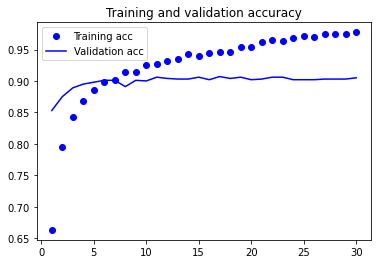

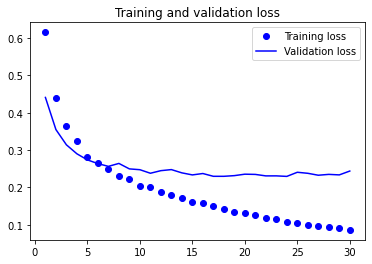

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

我们的验证精度达到了约  90%，比上一节从头开始训练的小型模型效果要好得多。但从图中也可以看出，虽然 dropout比率相当大，但模型几乎从一开始就过拟合。这是因为本方法没有使用数据增强，而数据增强对防止小型图像数据集的过拟合非常重要。

#### 5.3.1.2.使用数据增强的特征提取

下面我们来看一下特征提取的第二种方法，它的速度更慢，计算代价更高，但在训练期间可以使用数据增强。这种方法就是：扩展conv_base模型，然后在输入数据上端到端地运行模型。


In [10]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


VGG16的卷积基有  14 714  688个参数，非常多。在其上添加的分类器有  200万个参数。   

在编译和训练模型之前，一定要“冻结”卷积基。冻结（freeze）一个或多个层是指在训练过程中保持其权重不变。如果不这么做，那么卷积基之前学到的表示将会在训练过程中被修改。因为其上添加的Dense层是随机初始化的，所以非常大的权重更新将会在网络中传播，对之前学到的表示造成很大破坏。   

在 Keras中，冻结网络的方法是将其trainable属性设为False。

In [13]:
print(len(model.trainable_weights))
conv_base.trainable=False  # 冻结网络
print(len(model.trainable_weights))

30
4


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255) # 注意，不能增强验证数据


train_generator= train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150), #将所有图像的大小调整为150*150
    batch_size=20,
    class_mode='binary') #因为使用了binary_crossentropy损失，所以需要用二进制标签

validation_generator= test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), #
              loss='binary_crossentropy',
              metrics=['acc'])

history=model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

### 5.3.2　微调模型
另一种广泛使用的模型复用方法是模型微调（fine-tuning），与特征提取互为补充。对于用于特征提取的冻结的模型基，微调是指将其顶部的几层“解冻”，并将这解冻的几层和新增加的部分（本例中是全连接分类器）联合训练（见图 5-19）。之所以叫作微调，是因为它只是略微调整了所复用模型中更加抽象的表示，以便让这些表示与手头的问题更加相关。   

前面说过，冻结 VGG16的卷积基是为了能够在上面训练一个随机初始化的分类器。同理，只有上面的分类器已经训练好了，才能微调卷积基的顶部几层。如果分类器没有训练好，那么训练期间通过网络传播的误差信号会特别大，微调的几层之前学到的表示都会被破坏。因此，微调网络的步骤如下。   

(1)在已经训练好的基网络（base  network）上添加自定义网络。

(2)冻结基网络。

(3)训练所添加的部分。

(4)解冻基网络的一些层。

(5)联合训练解冻的这些层和添加的部分。   

你在做特征提取时已经完成了前三个步骤。我们继续进行第四步：先解冻 conv_base，然后冻结其中的部分层。

In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

我们将微调最后三个卷积层，也就是说，直到block4_pool的所有层都应该被冻结，而block5_conv1、block5_conv2和block5_conv3三层应该是可训练的。   

为什么不微调更多层？为什么不微调整个卷积基？你当然可以这么做，但需要考虑以下几点。

卷积基中更靠底部的层编码的是更加通用的可复用特征，而更靠顶部的层编码的是更专业化的特征。微调这些更专业化的特征更加有用，因为它们需要在你的新问题上改变用途。微调更靠底部的层，得到的回报会更少。
训练的参数越多，过拟合的风险越大。卷积基有    1500万个参数，所以在你的小型数据集上训练这么多参数是有风险的。
因此，在这种情况下，一个好策略是仅微调卷积基最后的两三层。我们从上一个例子结束的地方开始，继续实现此方法。

In [17]:
# 冻结直到某一层的所有层

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable: # 将 block5_conv1后的layer.trainable都设置为 True
        layer.trainable = True
    else:
        layer.trainable = False

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
2
2
2
2


现在你可以开始微调网络。我们将使用学习率非常小的 RMSProp优化器来实现。之所以让学习率很小，是因为对于微调的三层表示，我们希望其变化范围不要太大。太大的权重更新可能会破坏这些表示。

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

In [ ]:
#可以在测试数据上最终评估这个模型
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

### 5.3.3　小结

下面是你应该从以上两节的练习中学到的要点。

卷积神经网络是用于计算机视觉任务的最佳机器学习模型。即使在非常小的数据集上也可以从头开始训练一个卷积神经网络，而且得到的结果还不错。  

在小型数据集上的主要问题是过拟合。在处理图像数据时，数据增强是一种降低过拟合的强大方法。   

利用特征提取，可以很容易将现有的卷积神经网络复用于新的数据集。对于小型图像数据集，这是一种很有价值的方法。   

作为特征提取的补充，你还可以使用微调，将现有模型之前学到的一些数据表示应用于新问题。这种方法可以进一步提高模型性能。
现在你已经拥有一套可靠的工具来处理图像分类问题，特别是对于小型数据集。